## Import files

In [1]:

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from doe import GP

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=20
axis_font = 18
subt_font = 18
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
pd.options.mode.chained_assignment = None  

# <change these to your paths> 
path_to_loss_file = '../../data/loss/structural_db_complete_distributions.pickle'
path_to_max_file = '../../data/loss/structural_db_complete_max_loss.pickle'

# also change this to point to the directory with the brace database
# (should be ../data/, I think)
path_to_braceShapes = '../../resource/'


In [2]:
import inverse as inv

main_obj = pd.read_pickle(path_to_loss_file)
df_loss = main_obj.loss_data
max_obj = pd.read_pickle(path_to_max_file)
df = inv.preprocess_data(main_obj, max_obj, db_string=path_to_braceShapes)


In [3]:

# view a bit of the data
pd.set_option('display.max_columns', None)
df.head()


,superstructure_system,isolator_system,num_frames,S_1,T_m,k_ratio,moat_ampli,RI,L_bldg,h_bldg,zeta_e,num_bays,num_stories,L_bay,h_story,S_s,W,W_s,w_fl,P_lc,all_w_cases,all_Plc_cases,mu_1,mu_2,R_1,R_2,T_e,k_e,Q,zeta_loop,D_m,d_bearing,d_lead,t_r,t,n_layers,N_lb,S_pad,S_2,wx,hx,h_col,hsx,Fx,Vs,T_fbe,beam,column,brace,gm_selected,scale_factor,sa_avg,sa_tm,sa_1,sa_tfb,constructed_moat,T_1,T_fb,T_ratio,gap_ratio,max_isol_disp,PID,PFV,PFA,RID,impacted,run_status,max_drift,collapse_prob,log_collapse_prob,log_drift,max_velo,max_accel,T_ratio_e,Bm,k2,k1,bldg_area,W_L,Tshift_coef,T_M_adj,sa_tm_adj,GR_OG,GR_shift_coef,sa_tm_shift,replacement_cost,total_cmp_cost,total_cmp_cost_ub,cmp_replace_cost_ratio,median_cost_ratio,cmp_cost_ratio,replacement_time,total_cmp_time,total_cmp_time_ub,cmp_replace_time_ratio,median_time_ratio,cmp_time_ratio,replacement_freq,B_50%,C_50%,D_50%,E_50%,cost_theta,cost_beta,time_l_theta,time_l_beta,cost_lam,cost_k,time_l_k,time_l_lam,cost_weibull_ks_pvalue,cost_lognormal_ks_pvalue,time_l_weibull_ks_pvalue,time_l_lognormal_ks_pvalue,cost_weibull_aic,cost_lognormal_aic,time_l_weibull_aic,time_l_lognormal_aic,steel_cost,steel_cost_per_sf,system
0,CBF,LRB,2.0,0.843053,3.361456,11.651215,0.533852,1.825811,228.89828,55.96046,0.174673,8,4,28.612285,13.990115,2.2815,24887.350813,19647.908536,"[2.8612285048189143, 2.8612285048189143, 2.861...","[4584.511991801436, 4584.511991801436, 4584.51...","{'1.4D': [2.00285995337324, 2.00285995337324, ...","{'1.4D': [3209.158394261005, 3209.158394261005...",NaN,NaN,NaN,NaN,3.361456,0.009042,0.050203,0.174674,19.478012,27.062414,5.756887,6.553734,0.344933,19.0,32.0,19.251843,4.05302,"[5239.442276344498, 5239.442276344498, 5239.44...","[167.88138105745742, 335.76276211491484, 503.6...","[167.88138105745742, 167.88138105745742, 167.8...","[167.88138105745742, 167.88138105745742, 167.8...","[77.6482106282171, 205.0501068522509, 361.8723...",1050.686385,0.572887,"[W36X160, W33X141, W33X141, W33X130]","[W14X120, W14X120, W14X120, W14X120]","[HSS8X8X5/16, HSS8X8X1/4, HSS8X8X1/4, HSS6X6X1/4]",RSN15_KERN_TAF021,5.332722,0.457718,0.190517,0.943795,1.722739,10.398366,1.398459,0.729426,4.608358,0.702771,10.8249,"[0.0016452092439332008, 0.0016374656812354568,...","[37.4653, 36.7192, 35.9945, 36.6202, 39.3401]","[0.47065217391304354, 0.26440734989648035, 0.1...","[3.728823268291737e-05, 3.7496713217087075e-05...",1,0,0.001645,4.196419e-07,-14.683864,-6.409888,39.3401,0.470652,5.867572,1.424020,0.006465,0.075321,261972.113817,11526.773008,1.0,3.361456,0.190517,0.702771,1.0,1.0,157183268.290335,6.634832e+07,8.399005e+07,0.422108,0.004211,0.009975,95619.821543,18979.885770,27132.266452,0.198493,0.003886,0.019578,0.000,2.144579e+05,1.403143e+05,2.578819e+05,0.000000,6.836625e+05,2.798914e-01,372.619184,6.324548e-01,9.004882e+05,1.594268,1.150998,557.317584,3.783591e-13,1.749285e-01,3.856888e-08,1.690837e-01,28819.964682,28437.965187,14490.588733,14231.016791,7.079132e+05,2.702246,CBF-LRB
1,CBF,LRB,2.0,1.008515,2.931504,8.332905,0.791085,0.971544,135.583077,67.976554,0.201248,5,5,27.116615,13.595311,2.2815,10570.093145,8731.816076,"[2.7116615339767955, 2.7116615339767955, 2.711...","[1470.6216549698775, 1470.6216549698775, 1470....","{'1.4D': [1.8981630737837567, 1.89816307378375...","{'1.4D': [1029.4351584789142, 1029.43515847891...",NaN,NaN,NaN,NaN,2.931504,0.011889,0.077853,0.201251,19.25918,34.812498,5.90977,13.374756,0.431444,31.0,20.0,19.882371,2.565467,"[1838.2770687123466, 1838.2770687123466, 1838....","[163.1437290993618, 326.2874581987236, 489.431...","[163.1437290993618, 163.1437290993618, 163.143...","[163.1437290993618, 163.1437290993618, 163.143...","[27.695692643559386, 101.0693110471186, 215.52...",1132.756991,0.662869,"[W40X199, W40X199, W40X167, W40X167, W33X130]","[W14X257, W14X257, W14X257, W14X257, W10X26]","[HSS10X10X3/8, HSS10X10X3/8, HSS10X10X5/16, HS...",RSN8597_SIERRA.MEX_CISWSHNN,18.877261,0.613309,0.411581,1.093088,2.03349,15.235654,1.472164,0.643693,4.554199,0.661241,16.10

Divide data into subsets

In [4]:
#%% subsets 
df_tfp = df[df['isolator_system'] == 'TFP']
df_lrb = df[df['isolator_system'] == 'LRB']

df_cbf = df[df['superstructure_system'] == 'CBF'].reset_index()
df_cbf['dummy_index'] = df_cbf['replacement_freq'] + df_cbf['index']*1e-9
df_mf = df[df['superstructure_system'] == 'MF'].reset_index()
df_mf['dummy_index'] = df_mf['replacement_freq'] + df_mf['index']*1e-9

df_mf_o = df_mf[df_mf['impacted'] == 0]
df_cbf_o = df_cbf[df_cbf['impacted'] == 0]

df_mf_tfp = df_tfp[df_tfp['superstructure_system'] == 'MF']
df_mf_lrb = df_lrb[df_lrb['superstructure_system'] == 'MF']

df_cbf_tfp = df_tfp[df_tfp['superstructure_system'] == 'CBF']
df_cbf_lrb = df_lrb[df_lrb['superstructure_system'] == 'CBF']


df_mf_tfp_i = df_mf_tfp[df_mf_tfp['impacted'] == 1]
df_mf_tfp_o = df_mf_tfp[df_mf_tfp['impacted'] == 0]
df_mf_lrb_i = df_mf_lrb[df_mf_lrb['impacted'] == 1]
df_mf_lrb_o = df_mf_lrb[df_mf_lrb['impacted'] == 0]

df_cbf_tfp_i = df_cbf_tfp[df_cbf_tfp['impacted'] == 1]
df_cbf_tfp_o = df_cbf_tfp[df_cbf_tfp['impacted'] == 0]
df_cbf_lrb_i = df_cbf_lrb[df_cbf_lrb['impacted'] == 1]
df_cbf_lrb_o = df_cbf_lrb[df_cbf_lrb['impacted'] == 0]

Simplify the GP $_\theta$ model into just directly predicting the DV from $X$

In [5]:

cost_var = 'cmp_cost_ratio'
time_var = 'cmp_time_ratio'
repl_var= 'replacement_freq'
covariate_list = ['gap_ratio', 'RI', 'T_ratio', 'zeta_e']

mdl_all = GP(df)
mdl_all.set_covariates(covariate_list)


#%% regression models: cost
mdl_cost_cbf_lrb = GP(df_cbf_lrb)
mdl_cost_cbf_lrb.set_covariates(covariate_list)
mdl_cost_cbf_lrb.set_outcome(cost_var)
mdl_cost_cbf_lrb.test_train_split(0.2)

mdl_cost_cbf_tfp = GP(df_cbf_tfp)
mdl_cost_cbf_tfp.set_covariates(covariate_list)
mdl_cost_cbf_tfp.set_outcome(cost_var)
mdl_cost_cbf_tfp.test_train_split(0.2)

mdl_cost_mf_lrb = GP(df_mf_lrb)
mdl_cost_mf_lrb.set_covariates(covariate_list)
mdl_cost_mf_lrb.set_outcome(cost_var)
mdl_cost_mf_lrb.test_train_split(0.2)

mdl_cost_mf_tfp = GP(df_mf_tfp)
mdl_cost_mf_tfp.set_covariates(covariate_list)
mdl_cost_mf_tfp.set_outcome(cost_var)
mdl_cost_mf_tfp.test_train_split(0.2)

print('======= cost regression per system  ========')
import time
t0 = time.time()

mdl_cost_cbf_lrb.fit_gpr(kernel_name='rbf_iso')
mdl_cost_cbf_tfp.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_lrb.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_tfp.fit_gpr(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPR training for cost done for 4 models in %.3f s" % tp)

# density estimation model to enable constructability 
print('======= Density estimation per system ========')

t0 = time.time()

mdl_cost_mf_lrb.fit_kde()
mdl_cost_cbf_lrb.fit_kde()
mdl_cost_mf_tfp.fit_kde()
mdl_cost_cbf_tfp.fit_kde()

tp = time.time() - t0

print("KDE training done for 4 models in %.3f s" % tp)


cost_regression_mdls = {'mdl_cost_cbf_lrb': mdl_cost_cbf_lrb,
                        'mdl_cost_cbf_tfp': mdl_cost_cbf_tfp,
                        'mdl_cost_mf_lrb': mdl_cost_mf_lrb,
                        'mdl_cost_mf_tfp': mdl_cost_mf_tfp}

======= cost regression per system  ========
GPR training for cost done for 4 models in 3.470 s
======= Density estimation per system ========
KDE training done for 4 models in 2.515 s


In [6]:
#%% regression models: time
mdl_time_cbf_lrb = GP(df_cbf_lrb)
mdl_time_cbf_lrb.set_covariates(covariate_list)
mdl_time_cbf_lrb.set_outcome(time_var)
mdl_time_cbf_lrb.test_train_split(0.2)

mdl_time_cbf_tfp = GP(df_cbf_tfp)
mdl_time_cbf_tfp.set_covariates(covariate_list)
mdl_time_cbf_tfp.set_outcome(time_var)
mdl_time_cbf_tfp.test_train_split(0.2)

mdl_time_mf_lrb = GP(df_mf_lrb)
mdl_time_mf_lrb.set_covariates(covariate_list)
mdl_time_mf_lrb.set_outcome(time_var)
mdl_time_mf_lrb.test_train_split(0.2)

mdl_time_mf_tfp = GP(df_mf_tfp)
mdl_time_mf_tfp.set_covariates(covariate_list)
mdl_time_mf_tfp.set_outcome(time_var)
mdl_time_mf_tfp.test_train_split(0.2)

print('======= time regression per system  ========')
import time
t0 = time.time()

mdl_time_cbf_lrb.fit_gpr(kernel_name='rbf_iso')
mdl_time_cbf_tfp.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_lrb.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_tfp.fit_gpr(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPR training for time done for 4 models in %.3f s" % tp)

time_regression_mdls = {'mdl_time_cbf_lrb': mdl_time_cbf_lrb,
                        'mdl_time_cbf_tfp': mdl_time_cbf_tfp,
                        'mdl_time_mf_lrb': mdl_time_mf_lrb,
                        'mdl_time_mf_tfp': mdl_time_mf_tfp}

======= time regression per system  ========
GPR training for time done for 4 models in 3.289 s


Load hazard scenario

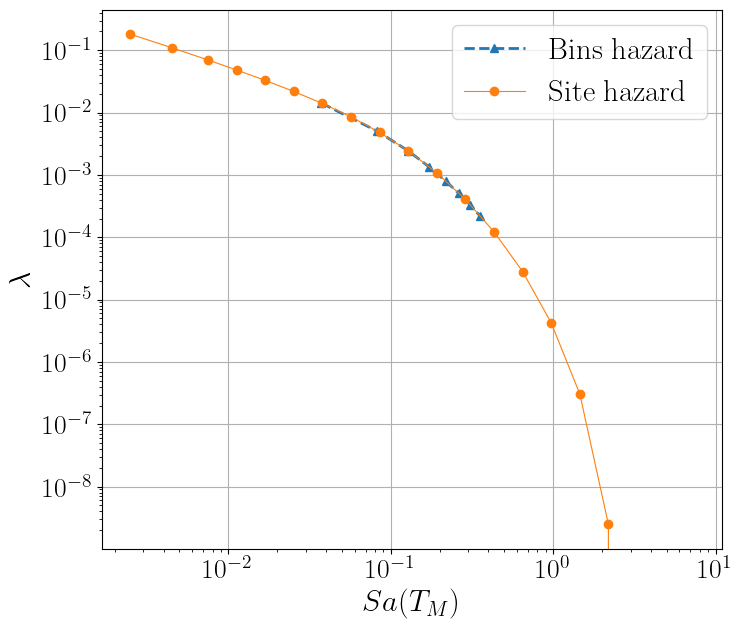

In [7]:
#%% define earthquake hazard
# reference: P-58 Implementation, Ch. 3.5

import json
import bisect
from scipy.interpolate import interp2d
with open('../../resource/hazard_curves/dwight_7th.json') as f:
    site_hazard_curves = json.load(f)['response']

np.seterr(divide='ignore')


def get_hazard_bins(T, hazard_curves, sa_max=1.016):
    T_list = [0.0, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0]
    idx_between = bisect.bisect(T_list, T)
    
    # 0 is total
    below_lambda = hazard_curves[idx_between-1]['data'][0]['yvalues']
    below_sa = hazard_curves[idx_between-1]['metadata']['xvalues']
    
    above_lambda = hazard_curves[idx_between]['data'][0]['yvalues']
    above_sa = hazard_curves[idx_between]['metadata']['xvalues']
    
    x2 = T_list[idx_between]
    x1 = T_list[idx_between-1]
    
    # assume that both series have the same length
    sa_T = [(g + h) / 2 for g, h in zip(below_sa, above_sa)]
    lambda_T = [y1+(T-x1)*(y2-y1)/(x2-x1) for y1, y2 in zip(below_lambda, above_lambda)]
    
    # sa max is max sa_avg from the dataset
    if T > 1.0:
        sa_min = 0.05/T
    else:
        sa_min = 0.05
        
    # use 8 bins
    sa_ends = np.linspace(sa_min, sa_max, 9)
    sa_bins = (sa_ends[1:] + sa_ends[:-1]) / 2
    
    # interpolate in logspace
    log_lambda = np.log(lambda_T)
    log_lambda[log_lambda == -np.inf] = -100
    lambda_bins = np.exp(np.interp(np.log(sa_bins), np.log(sa_T), log_lambda))
    
    # from here, methodology is to use sa_bins to scale ground motions and analyze
    return(sa_bins, lambda_bins, sa_T, lambda_T)

sa_bins, lambda_bins, sa_T, lambda_T = get_hazard_bins(3.36, site_hazard_curves,
                                                       sa_max=0.376)


plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=22
axis_font = 22
subt_font = 22
label_size = 20
clabel_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
plt.close('all')

fig = plt.figure(figsize=(8,7))
ax=fig.add_subplot(1, 1, 1)

ax.loglog(sa_bins,lambda_bins, '--^', label='Bins hazard', linewidth=2.0)
ax.loglog(sa_T,lambda_T, '-o', label='Site hazard', linewidth=0.8)
ax.legend(fontsize=axis_font)
ax.set_xlabel(r'$Sa(T_M)$', fontsize=axis_font)
ax.set_ylabel(r'$\lambda$', fontsize=axis_font)
ax.grid()

Scatterhist plotting

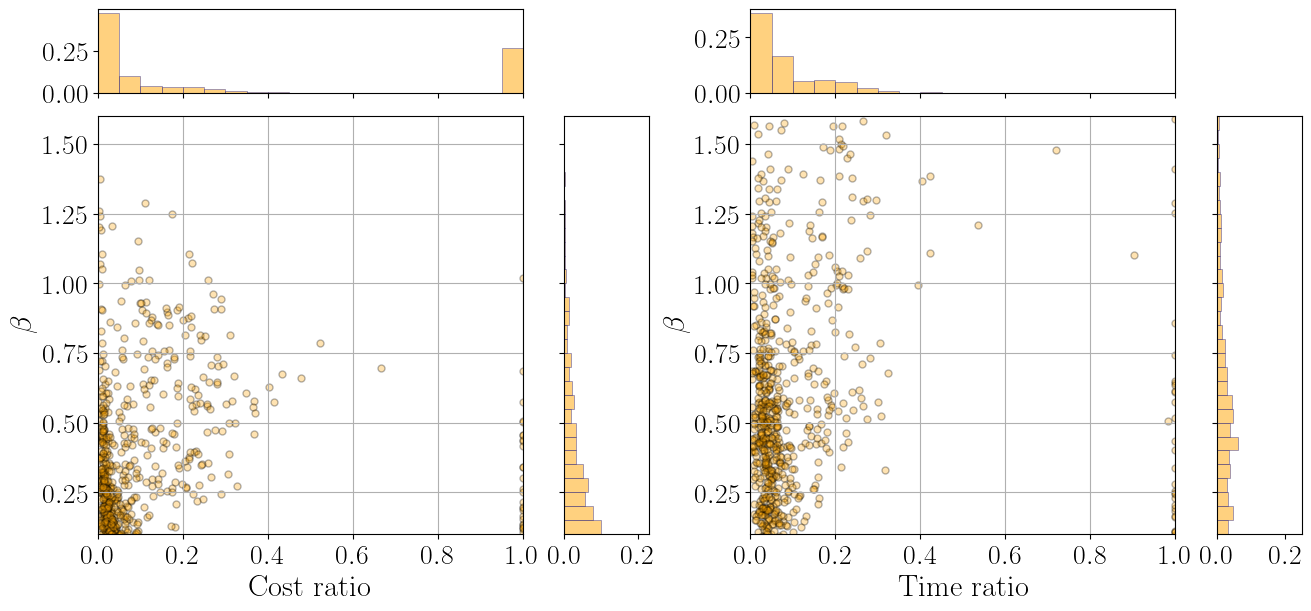

In [8]:
#%%
def scatter_hist(x, y, c, alpha, ax, ax_histx, ax_histy, label=None):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    cmap = plt.cm.Blues
    ax.scatter(x, y, alpha=alpha, edgecolors='black', s=25, facecolors=c,
               label=label)

    # now determine nice limits by hand:
    binwidth = 0.05
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    
    if y.name == 'zeta_e':
        binwidth = 0.02
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        
        bin_y = np.arange(-lim, lim + binwidth, binwidth)
    elif y.name == 'RI':
        binwidth = 0.15
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        
        bin_y = np.arange(-lim, lim + binwidth, binwidth)
    else:
        bin_y = bins
    ax_histx.hist(x, bins=bins, alpha = 0.5, weights=np.ones(len(x)) / len(x),
                  facecolor = c, edgecolor='navy', linewidth=0.5)
    ax_histy.hist(y, bins=bin_y, orientation='horizontal', alpha = 0.5, weights=np.ones(len(x)) / len(x),
                  facecolor = c, edgecolor='navy', linewidth=0.5)


plt.close('all')
fig = plt.figure(figsize=(13, 6), layout='constrained')

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(5, 1, 5, 1), height_ratios=(1, 5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0., hspace=0.)
# # Create the Axes.
# fig = plt.figure(figsize=(13, 10))
# ax1=fig.add_subplot(2, 2, 1)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(df[cost_var], df['cost_beta'], 'orange', 0.3, ax, ax_histx, ax_histy)
ax.set_xlabel(r'Cost ratio', fontsize=axis_font)
ax.set_ylabel(r'$\beta$', fontsize=axis_font)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.1, 1.6])
ax.grid()

ax = fig.add_subplot(gs[1, 2])
ax_histx = fig.add_subplot(gs[0, 2], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 3], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(df[time_var], df['time_l_beta'], 'orange', 0.3, ax, ax_histx, ax_histy)

ax.set_xlabel(r'Time ratio', fontsize=axis_font)
ax.set_ylabel(r'$\beta$', fontsize=axis_font)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.1, 1.6])
ax.grid()

Rebuild loss curve from distribution stats

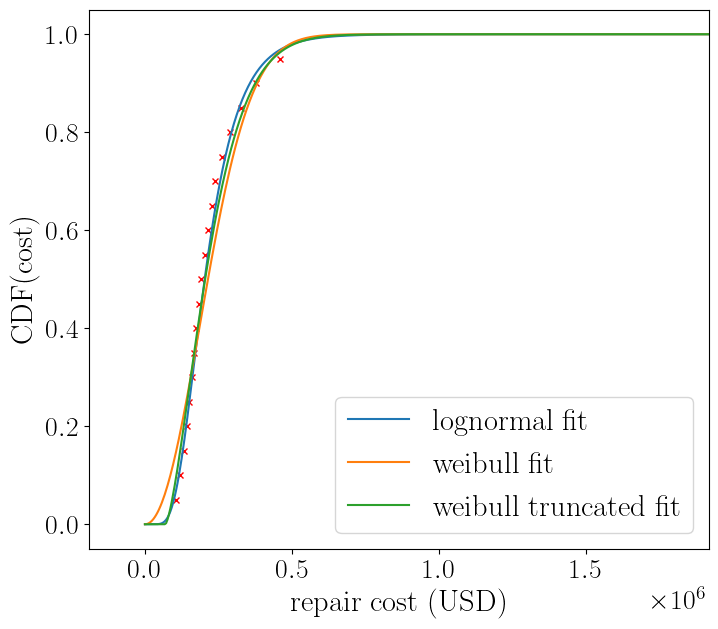

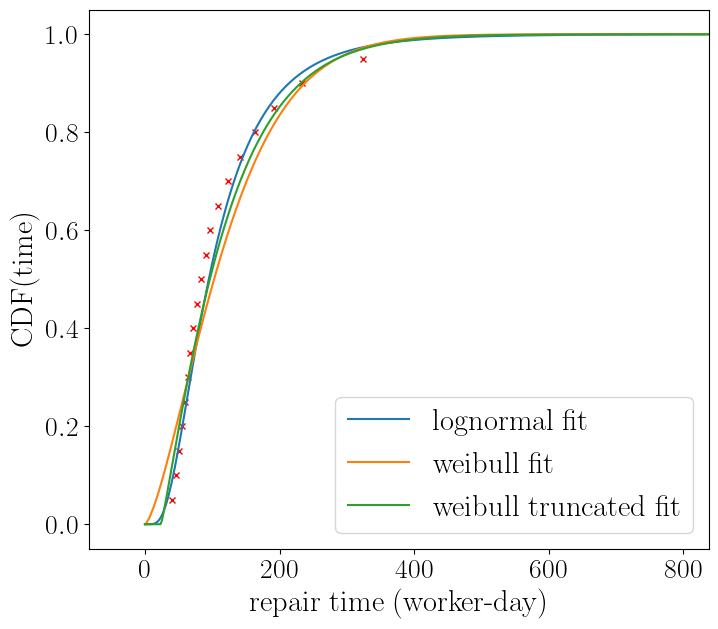

In [9]:
#%% rebuild loss curves from distros

from scipy.stats import norm

# make lambda function for generic lognormal distribution
import numpy as np
lognorm_f = lambda x,theta,beta: norm(np.log(theta), beta**0.5).cdf(np.log(x))

# make lambda function for generic weibull distribution
from scipy.stats import weibull_min
weibull_f = lambda x,k,lam,loc: weibull_min(k, loc=loc, scale=lam).cdf(x)

#%%  rebuilt curves

def plot_loss(row):
    # plot lognormal fits
    
    import matplotlib.pyplot as plt
    plt.close('all')
    fig = plt.figure(figsize=(8, 7))
    ax1=fig.add_subplot(1, 1, 1)
    
    # res = ecdf(row['repair_cost'])
    ecdf_prob = row['cost_quantiles'].index
    ecdf_values = row['cost_quantiles'].values
    median_val = row['cost_50%']
    ax1.plot([ecdf_values], [ecdf_prob], 
              marker='x', markersize=5, color="red")
    
    xx_pr = np.linspace(1e-4, 10*median_val, 400)
    p = lognorm_f(xx_pr, row['cost_theta'], row['cost_beta'])
    ax1.plot(xx_pr, p, label='lognormal fit')
    p = weibull_f(xx_pr, row['cost_k'], row['cost_lam'], 0)
    ax1.plot(xx_pr, p, label='weibull fit')  
    p = weibull_f(xx_pr, row['cost_k_trunc'], row['cost_lam_trunc'], row['cost_min'])
    ax1.plot(xx_pr, p, label='weibull truncated fit') 
    ax1.set_xlim([-median_val, 10*median_val])
    ax1.set_ylabel('CDF(cost)', fontsize=axis_font)
    ax1.set_xlabel('repair cost (USD)', fontsize=axis_font)
    ax1.legend(fontsize=axis_font)
    
    
    fig = plt.figure(figsize=(8, 7))
    ax1=fig.add_subplot(1, 1, 1)
    # res = ecdf(row['repair_cost'])
    ecdf_prob = row['time_l_quantiles'].index
    ecdf_values = row['time_l_quantiles'].values
    median_val = row['time_l_50%']
    ax1.plot([ecdf_values], [ecdf_prob], 
              marker='x', markersize=5, color="red")
    
    xx_pr = np.linspace(1e-4, 10*median_val, 400)
    p = lognorm_f(xx_pr, row['time_l_theta'], row['time_l_beta'])
    ax1.plot(xx_pr, p, label='lognormal fit')
    p = weibull_f(xx_pr, row['time_l_k'], row['time_l_lam'], 0)
    ax1.plot(xx_pr, p, label='weibull fit')  
    p = weibull_f(xx_pr, row['time_l_k_trunc'], row['time_l_lam_trunc'], row['time_l_min'])
    ax1.plot(xx_pr, p, label='weibull truncated fit') 
    ax1.set_xlim([-median_val, 10*median_val])
    ax1.set_ylabel('CDF(time)', fontsize=axis_font)
    ax1.set_xlabel('repair time (worker-day)', fontsize=axis_font)
    ax1.legend(fontsize=axis_font)

    return

current_idx = 299
current_row = df_loss.iloc[current_idx]
plot_loss(current_row)

Theta-beta model

In [10]:
#%% regression models: beta
# goal: E[beta|theta]

### cost
beta_covariates = [cost_var]
mdl_beta_cost_mf_tfp = GP(df_mf_tfp)
mdl_beta_cost_mf_tfp.set_covariates(beta_covariates)
mdl_beta_cost_mf_tfp.set_outcome('cost_beta')
mdl_beta_cost_mf_tfp.test_train_split(0.2)

mdl_beta_cost_mf_lrb = GP(df_mf_lrb)
mdl_beta_cost_mf_lrb.set_covariates(beta_covariates)
mdl_beta_cost_mf_lrb.set_outcome('cost_beta')
mdl_beta_cost_mf_lrb.test_train_split(0.2)

mdl_beta_cost_cbf_tfp = GP(df_cbf_tfp)
mdl_beta_cost_cbf_tfp.set_covariates(beta_covariates)
mdl_beta_cost_cbf_tfp.set_outcome('cost_beta')
mdl_beta_cost_cbf_tfp.test_train_split(0.2)

mdl_beta_cost_cbf_lrb = GP(df_cbf_lrb)
mdl_beta_cost_cbf_lrb.set_covariates(beta_covariates)
mdl_beta_cost_cbf_lrb.set_outcome('cost_beta')
mdl_beta_cost_cbf_lrb.test_train_split(0.2)

### time
beta_covariates = [time_var]
mdl_beta_time_mf_tfp = GP(df_mf_tfp)
mdl_beta_time_mf_tfp.set_covariates(beta_covariates)
mdl_beta_time_mf_tfp.set_outcome('time_l_beta')
mdl_beta_time_mf_tfp.test_train_split(0.2)

mdl_beta_time_mf_lrb = GP(df_mf_lrb)
mdl_beta_time_mf_lrb.set_covariates(beta_covariates)
mdl_beta_time_mf_lrb.set_outcome('time_l_beta')
mdl_beta_time_mf_lrb.test_train_split(0.2)

mdl_beta_time_cbf_tfp = GP(df_cbf_tfp)
mdl_beta_time_cbf_tfp.set_covariates(beta_covariates)
mdl_beta_time_cbf_tfp.set_outcome('time_l_beta')
mdl_beta_time_cbf_tfp.test_train_split(0.2)

mdl_beta_time_cbf_lrb = GP(df_cbf_lrb)
mdl_beta_time_cbf_lrb.set_covariates(beta_covariates)
mdl_beta_time_cbf_lrb.set_outcome('time_l_beta')
mdl_beta_time_cbf_lrb.test_train_split(0.2)

print('======= beta regression per system  ========')
t0 = time.time()

# note, fitting kernel ridge is just kernel regression here bc only one feature
mdl_beta_cost_mf_tfp.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_cost_mf_lrb.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_cost_cbf_tfp.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_cost_cbf_lrb.fit_kernel_ridge(kernel_name='laplacian')

mdl_beta_time_mf_tfp.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_time_mf_lrb.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_time_cbf_tfp.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_time_cbf_lrb.fit_kernel_ridge(kernel_name='laplacian')

tp = time.time() - t0

print("KR training for beta done for 8 models in %.3f s" % tp)

beta_regression_mdls = {'mdl_beta_cost_mf_tfp': mdl_beta_cost_mf_tfp,
                        'mdl_beta_cost_mf_lrb': mdl_beta_cost_mf_lrb,
                        'mdl_beta_cost_cbf_tfp': mdl_beta_cost_cbf_tfp,
                        'mdl_beta_cost_cbf_lrb': mdl_beta_cost_cbf_lrb,
                        'mdl_beta_time_mf_tfp': mdl_beta_time_mf_tfp,
                        'mdl_beta_time_mf_lrb': mdl_beta_time_mf_lrb,
                        'mdl_beta_time_cbf_tfp': mdl_beta_time_cbf_tfp,
                        'mdl_beta_time_cbf_lrb': mdl_beta_time_cbf_lrb}

mdl_beta_cost_cbf_lrb.fit_poly(degree=5)

======= beta regression per system  ========
The best kernel ridge parameters are {'kr__alpha': 0.0001, 'kr__gamma': 0.0001}
The best kernel ridge parameters are {'kr__alpha': 0.0001, 'kr__gamma': 0.0001}
The best kernel ridge parameters are {'kr__alpha': 0.001, 'kr__gamma': 0.1}
The best kernel ridge parameters are {'kr__alpha': 0.0001, 'kr__gamma': 0.01}
The best kernel ridge parameters are {'kr__alpha': 0.0001, 'kr__gamma': 0.0001}
The best kernel ridge parameters are {'kr__alpha': 1.0, 'kr__gamma': 0.1}
The best kernel ridge parameters are {'kr__alpha': 0.1, 'kr__gamma': 1.0}
The best kernel ridge parameters are {'kr__alpha': 0.0001, 'kr__gamma': 0.0001}
KR training for beta done for 8 models in 14.146 s


Plot theta-beta regressions

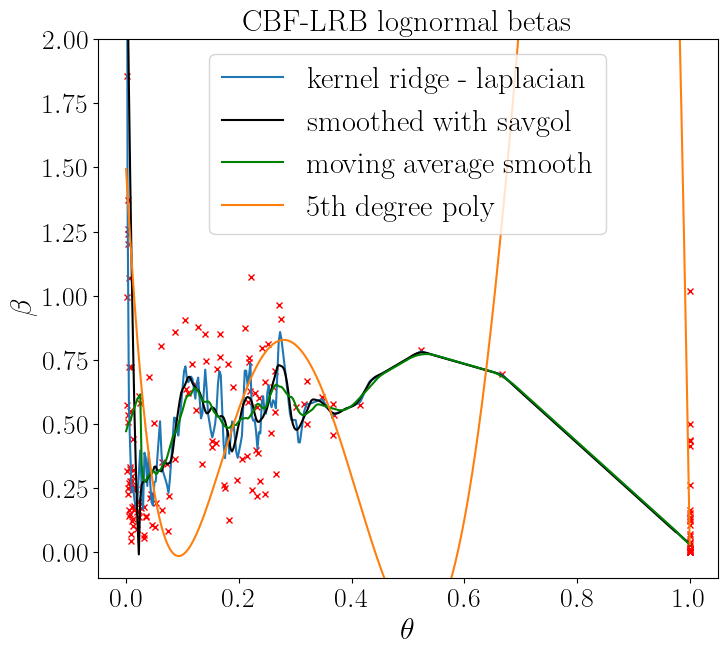

In [11]:
# low loss & extremely high loss = less dispersion
# extremely low loss: variance high bc of scaling/relative
# moderate loss: greater dispersion
import matplotlib.pyplot as plt
plt.close('all')
fig = plt.figure(figsize=(8, 7))
ax1=fig.add_subplot(1, 1, 1)

ax1.plot([np.array(mdl_beta_cost_cbf_lrb.X_train).ravel()], [mdl_beta_cost_cbf_lrb.y_train], 
          marker='x', markersize=5, color="red")

nplot = 400
xx_pr = np.linspace(1e-4, 1.0, nplot).reshape(-1,1)
yy_pr = mdl_beta_cost_cbf_lrb.kr.predict(xx_pr)
ax1.plot(xx_pr, yy_pr, label='kernel ridge - laplacian')

# TODO: in truth, you should not use filter/smoothing, but rather achieve smoothing
# through kernel hyperparameter bounds

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    # cumsum = np.cumsum(np.insert(y, 0, 0)) 
    # return (cumsum[box_pts:] - cumsum[:-box_pts]) / float(box_pts)
    return y_smooth

from scipy.signal import savgol_filter

y_sg = savgol_filter(yy_pr.ravel(), int(.05*nplot), 2)
ax1.plot(xx_pr, y_sg, color='black', label='smoothed with savgol')

y_sm = smooth(yy_pr.ravel(), int(.05*nplot))
ax1.plot(xx_pr, y_sm, color='green', label='moving average smooth')

# yy_pr = mdl_beta_cost_cbf_lrb.o_ridge.predict(xx_pr)
# ax1.plot(xx_pr, yy_pr, label='ordinary ridge')

# yy_pr = mdl_beta_cost_cbf_lrb.gpr.predict(xx_pr)
# ax1.plot(xx_pr, yy_pr, label='gpr-rq')

yy_pr = mdl_beta_cost_cbf_lrb.poly.predict(xx_pr)
ax1.plot(xx_pr, yy_pr, label='5th degree poly')
ax1.set_ylim([-.1, 2])
ax1.set_title(r'CBF-LRB lognormal betas', fontsize=axis_font)
ax1.set_xlabel(r'$\theta$', fontsize=axis_font)
ax1.set_ylabel(r'$\beta$', fontsize=axis_font)
ax1.legend(fontsize=axis_font)


Calculate mean annual cumulative loss

In [12]:
#%% calculate lifetime loss, annualized


from scipy.signal import savgol_filter


def calculate_lifetime_loss(row, impact_clfs, cost_regs, time_regs, beta_regs,
                            cost_var='cmp_cost_ratio', time_var='cmp_time_ratio'):
    
    # here, we have to hack together a representation of the expected loss at different sa
    T = row['T_m']
    
    # use maximum as 1.5* mce level Sa(T_m)
    mce_Sa_Tm = row['S_1']/row['T_m']
    sa_bins, lambda_bins, sa_T, lambda_T = get_hazard_bins(T, site_hazard_curves,
                                                            sa_max=1.5*mce_Sa_Tm)
    
    
    # sa_bins, lambda_bins, sa_T, lambda_T = get_hazard_bins(T, site_hazard_curves)
    
    
    # how are each design variables affected by changing Sa
    # only GR changes
    GR_bins = row['gap_ratio']*row['sa_tm']/sa_bins
    
    # set of new design variables corresponding to the bins' hazards
    X_bins = pd.DataFrame({'gap_ratio':GR_bins,
                         'RI':np.repeat(row['RI'], len(GR_bins)),
                         'T_ratio':np.repeat(row['T_ratio'], len(GR_bins)),
                         'zeta_e':np.repeat(row['zeta_e'], len(GR_bins))
                         })
    
    
    ############################################################################
    # use GP to find the 
    ############################################################################
    
    # pick the correct GP models
    # get system name
    system_name = row.system.lower().replace('-','_')
    
    # identify cost models
    mdl_cost_name = 'mdl_cost_' + system_name 
    mdl_cost = cost_regs[mdl_cost_name]
    
    # identify time models
    mdl_time_name = 'mdl_time_' + system_name
    mdl_time = time_regs[mdl_time_name]
    
    # identify beta models
    mdl_cost_beta_name = 'mdl_beta_cost_' + system_name
    mdl_time_beta_name = 'mdl_beta_time_' + system_name
    
    mdl_cost_beta = beta_regs[mdl_cost_beta_name]
    mdl_time_beta = beta_regs[mdl_time_beta_name]
    
    # for the set of "new" design variables, use GP to calculate loss ratio
    # assumes GPC/GPR, predict the outcome for the design space
    cost_ratio_bins = mdl_cost.gpr.predict(X_bins)
    time_ratio_bins = mdl_time.gpr.predict(X_bins)
    
    # predict dispersion given theta for each bin
    
    # using true kr to find beta from theta
    
    # cost_beta_bins = mdl_cost_beta.kr.predict(
    #     np.array(cost_ratio_bins[cost_var+'_pred']).reshape(-1,1))
    
    # time_beta_bins = mdl_time_beta.kr.predict(
    #     np.array(time_ratio_bins[time_var+'_pred']).reshape(-1,1))
    
    # using kr + savgol filter smoothing to find beta from theta
    nplot = 400
    xx_pr = np.linspace(1e-4, 1.2, nplot).reshape(-1,1)
    yy_pr = mdl_cost_beta.kr.predict(xx_pr)
    y_sg = savgol_filter(yy_pr.ravel(), int(.05*nplot), 2)
    y_sm = smooth(yy_pr.ravel(), int(.05*nplot))
    # cost_beta_bins = np.interp(cost_ratio_bins[cost_var+'_pred'].values, 
    #                            xx_pr.ravel(), y_sg)
    cost_beta_bins = np.interp(cost_ratio_bins, 
                                xx_pr.ravel(), y_sm)
    
    yy_pr = mdl_time_beta.kr.predict(xx_pr)
    y_sg = savgol_filter(yy_pr.ravel(), int(.05*nplot), 2)
    y_sm = smooth(yy_pr.ravel(), int(.05*nplot))
    # time_beta_bins = np.interp(time_ratio_bins[time_var+'_pred'].values, 
    #                            xx_pr.ravel(), y_sg)
    time_beta_bins = np.interp(time_ratio_bins, 
                                xx_pr.ravel(), y_sm)
    
    # unnormalize loss ratio back to loss
    cost_bins = cost_ratio_bins*row.total_cmp_cost
    time_bins = time_ratio_bins*row.total_cmp_time
    
    cost_bins[cost_bins < 0.0] = 1.0
    time_bins[time_bins < 0.0] = 0.04167
    
    # set any <0 cost to a dollar
    # set any <0 time to 30 mins
    
    # make exceedance curve for each scenario
    # use total replacement just to have a bigger number
    cost_loss_values = np.linspace(1e-4, row['replacement_cost'], 1000)
    time_loss_values = np.linspace(1e-4, row['replacement_time'], 1000)
    
    
    # cost_loss_values = np.linspace(1e-4, row['total_cmp_cost'], 1000)
    # time_loss_values = np.linspace(1e-4, row['total_cmp_time'], 1000)
    
    cost_scns = np.zeros([len(cost_loss_values), len(cost_bins)])
    time_scns = np.zeros([len(time_loss_values), len(time_bins)])
    
    
    for scn_idx in range(len(cost_bins)):
        
        cost_scns[:,scn_idx] = lognorm_f(cost_loss_values, cost_bins[scn_idx], cost_beta_bins[scn_idx])
        time_scns[:,scn_idx] = lognorm_f(time_loss_values, time_bins[scn_idx], time_beta_bins[scn_idx])
        
    cost_scns[cost_loss_values > row['total_cmp_cost_ub'], :] = 1.0
    time_scns[time_loss_values > row['total_cmp_time_ub'], :] = 1.0
    
    pr_exceedance_cost = 1 - cost_scns
    pr_exceedance_time = 1 - time_scns
    
    cost_loss_rates = np.multiply(pr_exceedance_cost, lambda_bins)
    time_loss_rates = np.multiply(pr_exceedance_time, lambda_bins)
    
    
    # import matplotlib.pyplot as plt
    # plt.close('all')
    # fig = plt.figure(figsize=(8, 7))
    # ax1=fig.add_subplot(1, 1, 1)
    # ax1.plot(sa_bins, cost_bins.ravel(), '-o')
    # ax1.set_xlabel(r'$Sa(T_M)$', fontsize=axis_font)
    # ax1.set_ylabel(r'GP predicted median repair cost (\$)', fontsize=axis_font)
    # ax1.grid()
    # plt.show()
    # # ax1.set_xlim([0, row['replacement_cost']])
    
    # import matplotlib.pyplot as plt
    # # plt.close('all')
    # fig = plt.figure(figsize=(9, 6))
    # ax1=fig.add_subplot(1, 1, 1)
    
    # for scn_idx in range(len(cost_bins)):
    #     ax1.plot(cost_loss_values, pr_exceedance_cost[:,scn_idx], label='scn_'+str(scn_idx))
    # ax1.legend()
    # ax1.set_xlabel(r'Cost (\$)', fontsize=axis_font)
    # ax1.set_ylabel(r'$Pr[X \geq \$]$', fontsize=axis_font)
    # ax1.grid()
    # ax1.set_xlim([0, row['replacement_cost']])
    
    
    # import matplotlib.pyplot as plt
    # # plt.close('all')
    # fig = plt.figure(figsize=(9, 7))
    # ax1=fig.add_subplot(1, 1, 1)
    
    # for scn_idx in range(len(cost_bins)):
    #     ax1.plot(cost_loss_values, cost_loss_rates[:,:scn_idx+1].sum(axis=1), label='scn_'+str(scn_idx))
    # ax1.legend()
    # ax1.set_xlabel(r'Cost (\$)', fontsize=axis_font)
    # ax1.set_ylabel(r'$Pr[X \geq \$]$', fontsize=axis_font)
    # ax1.grid()
    # ax1.set_xlim([0, row['replacement_cost']])
    
    # fig = plt.figure(figsize=(9, 7))
    # ax1=fig.add_subplot(1, 1, 1)
    
    # for scn_idx in range(len(time_bins)):
    #     ax1.plot(time_loss_values, time_loss_rates[:,:scn_idx+1].sum(axis=1), label='scn_'+str(scn_idx))
    # ax1.legend()
    # ax1.set_xlabel(r'time (man-hour)', fontsize=axis_font)
    # ax1.set_ylabel(r'$Pr[X \geq t]$', fontsize=axis_font)
    # ax1.grid()
    # ax1.set_xlim([0, row['replacement_time']])
    
    # breakpoint()
    
    # multiply scenarios' exceedance curve with corresponding return rate
    # sum across all scenarios
    agg_cost_exceedance_rate = pr_exceedance_cost @ lambda_bins
    agg_time_exceedance_rate = pr_exceedance_time @ lambda_bins
    
    # integrate to attain lifetime dollar, time
    mean_cumulative_annual_cost = np.trapz(agg_cost_exceedance_rate, cost_loss_values)
    mean_cumulative_annual_time = np.trapz(agg_time_exceedance_rate, time_loss_values)
    
    # renormalize
    
    return mean_cumulative_annual_cost, mean_cumulative_annual_time

Execute MCAC calculations

In [27]:
#%% 

row_no = 0
row = df.iloc[row_no]
mcac, mcat = calculate_lifetime_loss(row,
                                     impact_clfs=impact_classification_mdls, 
                                    cost_regs=cost_regression_mdls, 
                                    time_regs=time_regression_mdls,
                                    beta_regs=beta_regression_mdls)
    


[0.24640796 0.06566837 0.36890087 0.5950772  0.74200909 0.84117819
 0.91152256 0.96361159]


KeyError: 'total_cmp_cost_ub'

In [ ]:
#%% 

t0 = time.time()
df[['mean_cumulative_annual_cost', 
    'mean_cumulative_annual_time']] = df.apply(
        lambda row: calculate_lifetime_loss(row, impact_clfs=impact_classification_mdls, 
                                            cost_regs=cost_regression_mdls, 
                                            time_regs=time_regression_mdls,
                                            beta_regs=beta_regression_mdls),
        axis='columns', result_type='expand')

tp = time.time() - t0
print("Calculated lifetime losses for 1000 points in  %.3f s" % tp)

#%%
df['annual_cost_ratio'] = df['mean_cumulative_annual_cost']/df['total_cmp_cost']
df['annual_time_ratio'] = df['mean_cumulative_annual_time']/df['total_cmp_time']


#%% re subsets

df_tfp = df[df['isolator_system'] == 'TFP']
df_lrb = df[df['isolator_system'] == 'LRB']

df_cbf = df[df['superstructure_system'] == 'CBF'].reset_index()
df_cbf['dummy_index'] = df_cbf['replacement_freq'] + df_cbf['index']*1e-9
df_mf = df[df['superstructure_system'] == 'MF'].reset_index()
df_mf['dummy_index'] = df_mf['replacement_freq'] + df_mf['index']*1e-9

df_mf_o = df_mf[df_mf['impacted'] == 0]
df_cbf_o = df_cbf[df_cbf['impacted'] == 0]

df_mf_tfp = df_tfp[df_tfp['superstructure_system'] == 'MF']
df_mf_lrb = df_lrb[df_lrb['superstructure_system'] == 'MF']

df_cbf_tfp = df_tfp[df_tfp['superstructure_system'] == 'CBF']
df_cbf_lrb = df_lrb[df_lrb['superstructure_system'] == 'CBF']


df_mf_tfp_i = df_mf_tfp[df_mf_tfp['impacted'] == 1]
df_mf_tfp_o = df_mf_tfp[df_mf_tfp['impacted'] == 0]
df_mf_lrb_i = df_mf_lrb[df_mf_lrb['impacted'] == 1]
df_mf_lrb_o = df_mf_lrb[df_mf_lrb['impacted'] == 0]

df_cbf_tfp_i = df_cbf_tfp[df_cbf_tfp['impacted'] == 1]
df_cbf_tfp_o = df_cbf_tfp[df_cbf_tfp['impacted'] == 0]
df_cbf_lrb_i = df_cbf_lrb[df_cbf_lrb['impacted'] == 1]
df_cbf_lrb_o = df_cbf_lrb[df_cbf_lrb['impacted'] == 0]

Build MCAC predictor

In [17]:
#%%

mdl_annual_cost = GP(df_mf_lrb)
mdl_annual_cost.set_covariates(covariate_list)
mdl_annual_cost.set_outcome('annual_cost_ratio')
mdl_annual_cost.test_train_split(0.2)

mdl_annual_cost.fit_gpr(kernel_name='rbf_iso')

Plot MCAC predictor

In [18]:
#%% sample for CBF-LRB

annual_cost_var = 'annual_cost_ratio'

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 18
subt_font = 18
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

fig = plt.figure(figsize=(16, 7))

xvar = 'gap_ratio'
yvar = 'RI'

res = 75
X_plot = make_2D_plotting_space(mdl_impact_mf_lrb.X, res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 2.0, fourth_var_set = 0.15)

Z = mdl_annual_cost.gpr.predict(X_plot)


xx = X_plot[xvar]
yy = X_plot[yvar]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_surf = np.array(Z).reshape(xx_pl.shape)

ax=fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(xx_pl, yy_pl, Z_surf, cmap='Blues',
                       linewidth=0, antialiased=False, alpha=0.6,
                       vmin=-0.1)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.scatter(df_mf_lrb[xvar], df_mf_lrb[yvar], df_mf_lrb[annual_cost_var], c=df_mf_lrb[annual_cost_var],
           edgecolors='k', alpha = 0.7, cmap='Blues')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
cset = ax.contour(xx_pl, yy_pl, Z_surf, zdir='x', offset=xlim[0], cmap='Blues_r')
cset = ax.contour(xx_pl, yy_pl, Z_surf, zdir='y', offset=ylim[1], cmap='Blues')
# ax.set_zlim([-0.1, 1.1])

ax.set_xlabel('Gap ratio', fontsize=axis_font)
ax.set_ylabel('$R_y$', fontsize=axis_font)
ax.set_zlabel('Annual repair cost (\%)', fontsize=axis_font)
ax.set_title('MF-LRB: $T_M/T_{fb} = 3.0$, $\zeta_M = 0.15$', fontsize=subt_font)

#################################
xvar = 'T_ratio'
yvar = 'zeta_e'

res = 75
X_plot = make_2D_plotting_space(mdl_impact_mf_lrb.X, res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 1.0, fourth_var_set = 2.0)

Z = mdl_annual_cost.gpr.predict(X_plot)

xx = X_plot[xvar]
yy = X_plot[yvar]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_surf = np.array(Z).reshape(xx_pl.shape)

ax=fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(xx_pl, yy_pl, Z_surf, cmap='Blues',
                       linewidth=0, antialiased=False, alpha=0.6,
                       vmin=-0.1)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.scatter(df_mf_lrb[xvar], df_mf_lrb[yvar], df_mf_lrb[annual_cost_var], c=df_mf_lrb[annual_cost_var],
           edgecolors='k', alpha = 0.7, cmap='Blues')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
cset = ax.contour(xx_pl, yy_pl, Z_surf, zdir='x', offset=xlim[0], cmap='Blues_r')
cset = ax.contour(xx_pl, yy_pl, Z_surf, zdir='y', offset=ylim[1], cmap='Blues')
# ax.set_zlim([-0.1, 1.1])

ax.set_xlabel('$T_M/ T_{fb}$', fontsize=axis_font)
ax.set_ylabel('$\zeta_M$', fontsize=axis_font)
ax.set_zlabel('Annual repair cost (\%)', fontsize=axis_font)
ax.set_title('MF-LRB: $GR = 1.0$, $R_y = 2.0$', fontsize=subt_font)
fig.tight_layout()

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../bd1ee3b29cb4e640ebdef25bddc487f4.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on bd1ee3b29cb4e640ebdef25bddc487f4.log.




Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f8e63e844c0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../bd1ee3b29cb4e640ebdef25bddc487f4.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on bd1ee3b29cb4e640ebdef25bddc487f4.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../bd1ee3b29cb4e640ebdef25bddc487f4.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on bd1ee3b29cb4e640ebdef25bddc487f4.log.




<Figure size 1600x700 with 2 Axes>